In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pickle

from top_bottom_moseq.util import load_matched_frames, points_2d_to_3d, load_intrinsics
from top_bottom_moseq.calibration import *

### Define params

In [2]:
calibration_prefix = '../../data/2022_12_16_calibration.rig2'
flatibration_prefix = '../../data/2022_12_16_flatibration.rig2'
intrinsics_prefix = 'rig2'
output_path = 'camera_3D_transforms.p'
camera_names = ['top','bottom']
checker_dims = [(6,8),(8,6)]

### Detect corners and project to 3D for each camera
Plot the deviation of inter-point distances to exclude bad checkerboard detections

3588it [14:08,  4.23it/s]


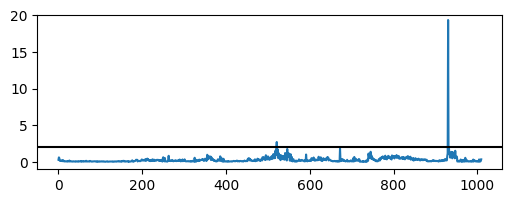

Corners already detected, re-loading...


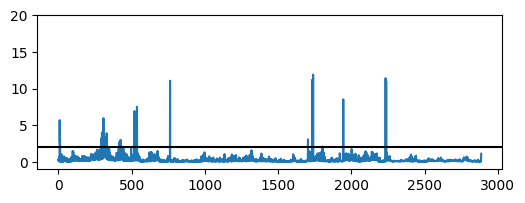

In [3]:
calibration_points = []
for name,dims in zip(camera_names,checker_dims):
    corners, ixs = detect_corners_from_video(calibration_prefix+'.'+name, dims, parallel=False)
    assert len(corners)>0, 'No checker points detected'
    intrinsics = load_intrinsics(intrinsics_prefix+'.'+name+'.json')
    corners_3d = np.array([points_2d_to_3d(points,intrinsics) for points in corners])
    
    
    # quality control: each frame should have the same set of distances between points
    # so for each point-set, find the distances to the first point
    # get the median of these distances across all point-sets
    # then exclude point-sets where the rmsd to the median exceeds 2mm
    distances = np.array([np.sqrt(((points-points[0,:])**2).sum(1)) for points in corners_3d])
    rmsd = np.mean((np.median(distances,axis=0)-distances)**2,axis=1)
    calibration_points.append({ix:points for ix,points,error in zip(ixs,corners_3d,rmsd) if error<2})
    
    plt.plot(rmsd)
    plt.axhline(2, c='k')
    plt.ylim([-1,20])
    plt.gcf().set_size_inches((6,2))
    plt.show()

In [10]:
# optionally save video of corner detections
for name in camera_names:
    save_corner_detection_video(calibration_prefix, name)

Corner detection video: 3588it [01:18, 45.62it/s]
Corner detection video: 3596it [01:26, 41.68it/s]


### Align timestamps and calculate projection params
Each projection is a matrix R and offset t that defines a 3D rigid transform to the coordinate system of the last camera

In [11]:
# filter to frames where calibration points were detected for all cameras
matched_timestamps = load_matched_frames(calibration_prefix, camera_names)
filtered_matched_timestamps = np.array([ixs for ixs in matched_timestamps if np.all([ix in ps for ix,ps in zip(ixs,calibration_points)])])
matched_calib_points = [np.array([ps[ix] for ix in filtered_matched_timestamps[:,i]]) for i,ps in enumerate(calibration_points)]


There are 4 ways to index the checker points. We will assume a consistent reindex between each pair of cameras and check which one minizes the error

In [29]:

projection_params = []
for calib_points,dims in zip(matched_calib_points[:-1], checker_dims[:-1]):
    param_for_each_reindex = []
    error_for_each_reindex = [] 
    reindexes,names = get_corner_label_reindexes(dims)
    for reindex in reindexes:
        source_points = calib_points[:,reindex,:].reshape(-1,3)
        target_points = matched_calib_points[-1].reshape(-1,3)
        R,t = rigid_transform_3D(source_points, target_points)
        error = np.mean((source_points.dot(R.T)+t - target_points)**2)
        param_for_each_reindex.append((R,t))
        error_for_each_reindex.append(round(error,1)) 
    best_reindex = np.argmin(error_for_each_reindex)
    projection_params.append(param_for_each_reindex[best_reindex])  
        
    print('Errors:')
    for name,err in zip(names,error_for_each_reindex):
        print('  {} ({})'.format(round(err,1),name))
        
    

Errors:
  2029.0 (identity)
  2712.6 (reverse)
  2497.4 (flip)
  2211.1 (flip+reverse)
  1.2 (transpose)
  4851.4 (transpose+reverse)
  1743.4 (transpose+flip)
  3109.3 (transpose+flip+reverse)


### Check the agreement of coordinates for each checker point between the top and bottom views

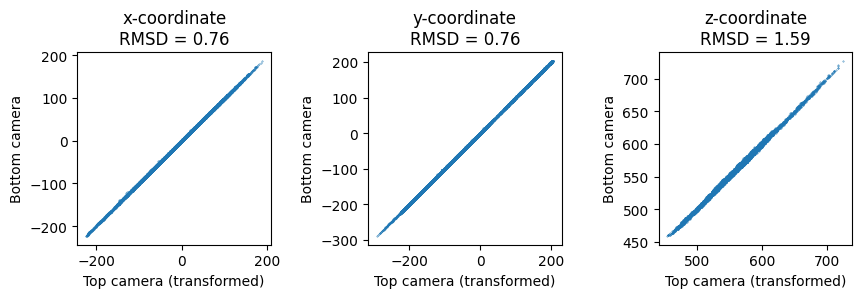

In [30]:
bottom_points = matched_calib_points[1].reshape(-1,3)
top_points = matched_calib_points[0][:,reindexes[best_reindex],:].reshape(-1,3)

R_top2bottom,t_top2bottom = projection_params[0]
top_points_transformed = top_points.dot(R_top2bottom.T)+t_top2bottom

fig,axs = plt.subplots(1,3)
for i,coord_name in enumerate(['x','y','z']):
    axs[i].scatter(top_points_transformed[:,i],bottom_points[:,i],s=.1)
    axs[i].set_xlabel('Top camera (transformed)')
    axs[i].set_ylabel('Bottom camera')
    rmsd = np.sqrt(np.mean((top_points_transformed[:,i]-bottom_points[:,i])**2))
    axs[i].set_title(coord_name+'-coordinate\nRMSD = '+str(round(rmsd,2)))
fig.subplots_adjust(wspace=0.5)
fig.set_size_inches((10,2.5))

### Next find the plane of the acryclic that the mouse walks on. 
Want a rigid transform for both cameras that maps to the z-axis to true-vertical. Will use recording where I kept the checker pattern flat the whole time.


In [33]:
corners,ixs = detect_corners_from_video(flatibration_prefix+'.bottom', checker_dims[-1])
intrinsics = load_intrinsics(intrinsics_prefix+'.bottom.json')
corners_3d = np.array([points_2d_to_3d(points,intrinsics) for points in corners]).reshape(-1,3)

1796it [05:22,  5.57it/s]


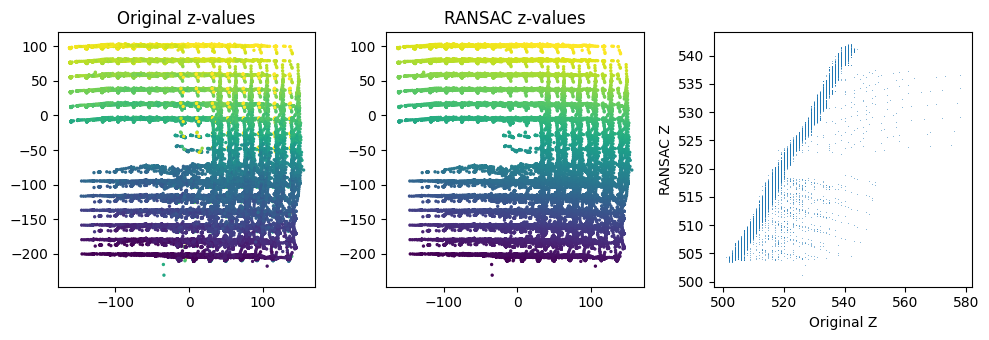

In [34]:
# fit plane using RANSAC from sklearn
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(residual_threshold=12).fit(corners_3d[:,:2],corners_3d[:,2])

# show agreement between ransac estimator and raw data
fig,axs = plt.subplots(1,3)
axs[0].scatter(corners_3d[:,0],corners_3d[:,1],c=corners_3d[:,2], vmin=np.percentile(corners_3d[:,2],1),vmax=np.percentile(corners_3d[:,2],99),s=2)
axs[1].scatter(corners_3d[:,0],corners_3d[:,1],c=ransac.predict(corners_3d[:,:2]), vmin=np.percentile(corners_3d[:,2],1),vmax=np.percentile(corners_3d[:,2],99),s=2)
axs[2].scatter(corners_3d[:,2],ransac.predict(corners_3d[:,:2]), s=.2, linewidth=0)
axs[0].set_title('Original z-values')
axs[1].set_title('RANSAC z-values')
axs[2].set_xlabel('Original Z')
axs[2].set_ylabel('RANSAC Z')
fig.set_size_inches((10,3.5))
plt.tight_layout()


Now we want a transformation from the bottom camera to the final coordinate system where the z-coordinate is orthogonal to the plane identified by RANSAC, and Z=0 represents the exact location of the plane. There are multiple ways to perform this transformation (any rotation added to the final coordinate system would still be a valid solution), so we'll just choose the one that is "smallest" according to some regularizer. 

The output of RANSAC is a regression equation $z=ax+by+t$. This means that (in the camera coordinate frame) the vectors (1,0,a) and (0,1,b) lie in the plane, so we want a vector that's orthogonal to both of these, i.e. a solution to the equations $x' + az' = 0, y'+bz=0$. This can easily be solved as $(x',y',z') = (-a, -b, 1)$.

Next we want a rigid transform. We can use the function ```rigid_transform_3D``` if we specify 3 target and source points. We already have the source-target pairs $(0,0,t) \to (0,0,0)$ and $(-a,-b,t+1) \to (0,0,\sqrt{a^2+b^2+1})$ and we can add the third pair $(1,0,t+a) \to (\sqrt{1+a^2},0,0)$. 



In [35]:
a,b = ransac.estimator_.coef_
t = ransac.estimator_.intercept_
source = np.array([[0,0,t],[-a,-b,t+1],[1,0,t+a]])
target = np.array([[0,0,0],[0,0,np.sqrt(a**2+b**2+1)],[np.sqrt(1+a**2),0,0]])
R_bottom2final, t_bottom2final = rigid_transform_3D(source,target)

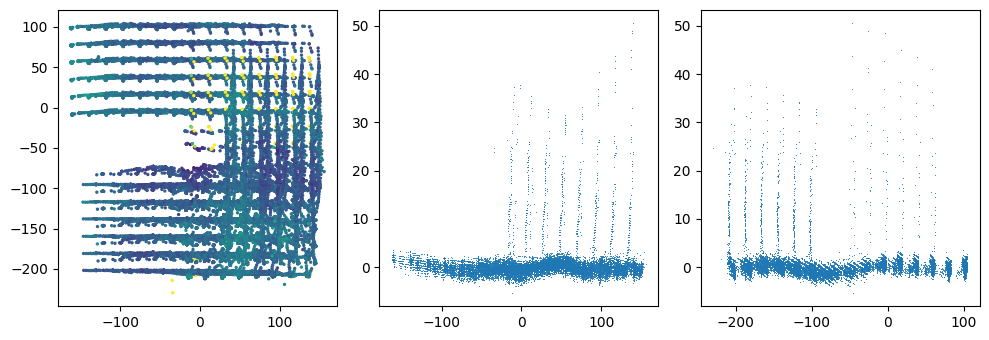

In [36]:
# Check that points are flat after transformation
corners_3d_transformed = corners_3d.dot(R_bottom2final.T) + t_bottom2final
fig,axs = plt.subplots(1,3)
axs[0].scatter(corners_3d_transformed[:,0],corners_3d_transformed[:,1],c=corners_3d_transformed[:,2], vmax=10,s=2)
axs[1].scatter(corners_3d_transformed[:,0],corners_3d_transformed[:,2],s=.4, linewidth=0)
axs[2].scatter(corners_3d_transformed[:,1],corners_3d_transformed[:,2],s=.4, linewidth=0)
fig.set_size_inches((10,3.5))
plt.tight_layout()

### Compose transformations top2bottom and bottom2final to get top2final, then save
For a pair of transformations $(R_1,t_1)$ and $(R_2,t_2)$ that each act on a point as $x \mapsto Rx+t$, the composition is 

$$x \mapsto R_2(R_1x + t_1) + t_2 = R_2R_1x + R_2t_1+t_2$$ which means $R_{1,2} = R_2R_1$ and $t_{1,2}=R_2t_1 + t_2$


In [37]:
R_top2final = R_bottom2final.dot(R_top2bottom)
t_top2final = R_bottom2final.dot(t_top2bottom) + t_bottom2final

In [38]:
pickle.dump({
    'top':    (R_top2final,t_top2final), 
    'bottom': (R_bottom2final,t_bottom2final)
}, open(output_path,'wb'))
